pip install tqdm ads transformers torch matplotlib streamlit

In [2]:
pip install tqdm ads transformers torch matplotlib streamlit

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached ads-0.12.7-py3-none-any.whl.metadata (1.8 kB)
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached streamlit-1.43.1-py2.py3-none-any.whl.metadata (8.9 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached mock-5.2.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (62 kB)
  Using cached regex-2024.11.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metad

In [3]:
from tqdm import tqdm
import ads
#import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
import numpy as np
#from sklearn.model_selection import train_test_split
#from safetensors.torch import save_file
from safetensors import safe_open
from transformers import get_linear_schedule_with_warmup
#import time
#import random
import torch
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#import json
import textwrap
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import streamlit as st
import io 
import os

In [4]:
import torch
print(torch.__version__)  # Should print 2.3.0

2.6.0


## Loading the model trained on triplet loss

In [5]:
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=True)

num_labels = 2

model_full = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_cased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

max_sequence_length = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model_full.bert
model.to(device)

file = './model_checkpoint.pth'
model.load_state_dict(torch.load(file,weights_only=True,map_location=torch.device('cpu')))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cpu


<All keys matched successfully>

In [6]:
def compute_embeddings(list_abstracts,model):
    

# Tokenize each inner list of texts
    tokenized_texts = [tokenizer.encode(text, padding='max_length', max_length=max_sequence_length,truncation=True, return_tensors="pt").squeeze() for text in list_abstracts]

# Pad each tensor in the list to ensure they are all the same length
    padded_texts = [
        torch.cat([tensor, torch.zeros(max_sequence_length - tensor.size(0), dtype=torch.long)]) for tensor in tokenized_texts
    ]


    tokenized_texts = torch.stack(tokenized_texts)
    print(tokenized_texts.shape)  # Should print (batch_size, 3, m
# attention masks    
    att_masks = []
    
    for ids in tokenized_texts:
        masks = [int(element > 0) for element in ids]
        att_masks.append(masks)
        
    padded_lists = [[mask + [0] * (max_sequence_length - len(mask)) for mask in att_masks]]
    att_masks = np.array(padded_lists).squeeze()
    att_masks = torch.Tensor(att_masks)
# computing the embeddings
    text = tokenized_texts
    mask = att_masks
    embedding = model(text, attention_mask=mask).last_hidden_state[:, 0]  

    return embedding.detach().numpy()
    


## downloading the new abstracts from arXiv API

In [7]:


def fetch_recent_arxiv_abstracts(domain="astro-ph.EP", days=1, max_results=200):
    # Base URL for arXiv API
    base_url = "http://export.arxiv.org/api/query"
    
    # Query parameters
    params = {
        "search_query": domain,
        "start": 0,
        "max_results": max_results,
        "sortBy": "submittedDate",
        "sortOrder": "descending",
    }
    
    # Fetch data from arXiv API
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print("Failed to fetch data.")
        return []
    
    # Parse the XML response
    root = ET.fromstring(response.content)
    
    # Namespace for arXiv XML
    ns = {"atom": "http://www.w3.org/2005/Atom"}
    
    # Calculate date N days ago
    date_limit = datetime.now() - timedelta(days=days)
    
    # Extract and filter abstracts
    abstracts = []
    titles = []
    for entry in root.findall("atom:entry", ns):
        # Extract publication date
        published_date = entry.find("atom:published", ns).text.strip()
        published_date = datetime.fromisoformat(published_date[:-1])  # Remove 'Z' and parse
        
        # Include only entries within the date range
        if published_date >= date_limit:
            title = entry.find("atom:title", ns).text.strip()
            abstract = entry.find("atom:summary", ns).text.strip()
            #print(f"Title: {title}")
            #print(f"Published Date: {published_date}")
            #print(f"Abstract: {abstract}\n")
            abstracts.append(abstract)
            titles.append(title)
    
    return abstracts,titles



In [8]:
# Example: Fetch abstracts from the last 7 days
recent_abstracts,recent_titles = fetch_recent_arxiv_abstracts(days=3)

print(len(recent_abstracts),' abstracts found')

7  abstracts found


In [9]:
recent_abstracts_embeddings = compute_embeddings(recent_abstracts,model)

torch.Size([7, 512])


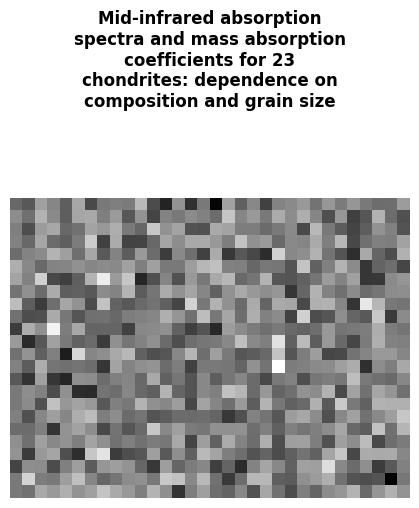

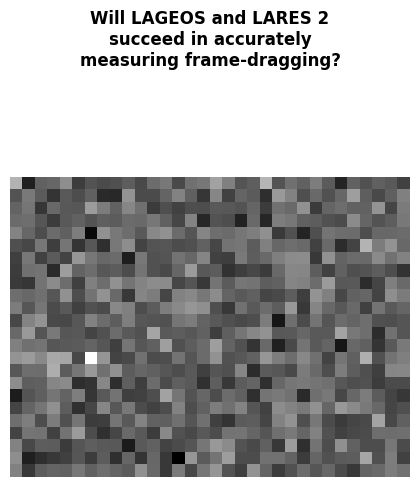

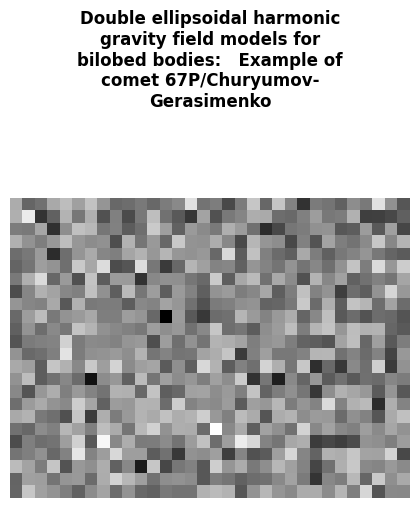

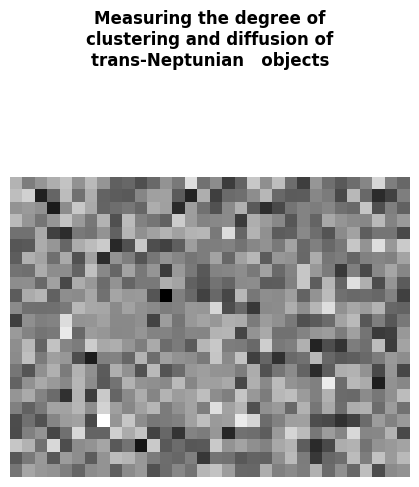

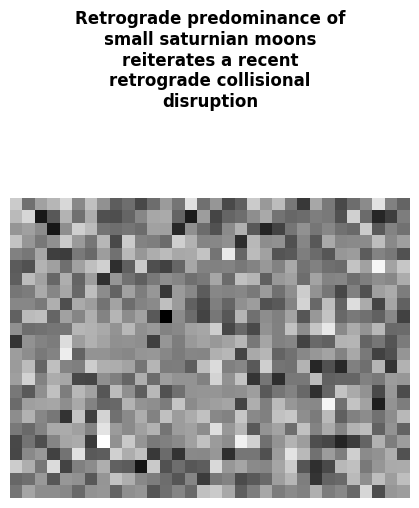

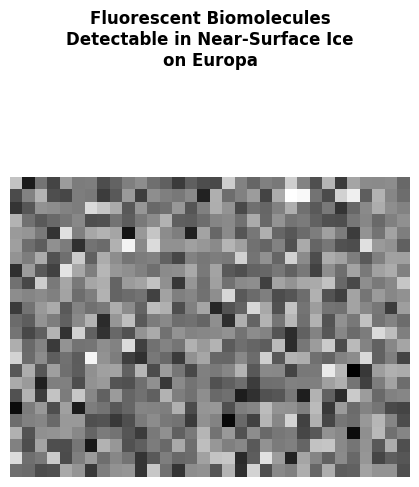

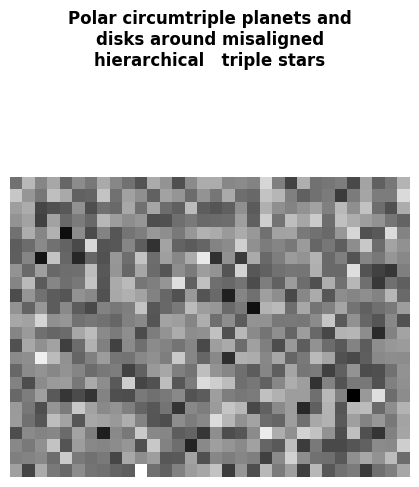

In [10]:



array = recent_abstracts_embeddings
N = np.shape(recent_abstracts_embeddings)[0]

# Normalize function (min-max normalization)
def normalize(arr):
    return (arr - arr.min(axis=1, keepdims=True)) / (arr.max(axis=1, keepdims=True) - arr.min(axis=1, keepdims=True))

def format_title(text, width=20):
    return "\n".join(textwrap.wrap(text, width))


# Normalize each row to be between 0 and 1
normalized_array = normalize(array)

# Fixed figure size (ensures all white areas are the same)
fig_width = 4  # Adjust for more spacing if needed
fig_height = 6  # Keep consistent for all

# Generate the plots
for i in range(N):
    matrix = normalized_array[i].reshape(24, 32)  # Reshape 
    
    # Create figure with fixed size
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))  
    ax.imshow(matrix, cmap='gray', interpolation='nearest')  # Display as B/W image
    ax.axis('off')  # Hide axes

    # Format title with a fixed width to ensure consistency
    title_text = format_title(recent_titles[i], width=30)
    fig.suptitle(title_text, fontsize=12, fontweight='bold', ha='center')

    # Ensure all figures have the same white space distribution
    fig.subplots_adjust(top=0.85, bottom=0.1)

    # Prevent Matplotlib from adjusting the layout dynamically
    fig.tight_layout(pad=0)  # Ensures uniform padding

    plt.show()


In [11]:
import pkg_resources
import sys

# Get a list of all loaded packages
loaded_packages = {module.split('.')[0] for module in sys.modules.keys()}

# Get installed packages and their versions
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

# Filter only the packages that are both installed and used
used_packages = {pkg: installed_packages[pkg] for pkg in loaded_packages if pkg in installed_packages}

# Write to requirements.txt
with open("requirements.txt", "w") as f:
    for pkg, version in used_packages.items():
        f.write(f"{pkg}=={version}\n")

print("requirements.txt file created with only imported packages!")


requirements.txt file created with only imported packages!


/var/folders/t7/jlvdg16d6hld9cb6bbmp47c40000gp/T/ipykernel_65046/1504413852.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [12]:
import sys
sys.version

'3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]'